# Introduction


**What?** Training a classifier for the CIFAR10 dataset



# Import modules

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [3]:
print("torch version: ",torch.__version__)
print("torchvision version:", torchvision.__version__)

torch version:  1.7.1
torchvision version: 0.8.2


# The CIFAR10 dataset

In [4]:
"""
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, 
‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color
images of 32x32 pixels in size.
"""

'\nFor this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, \n‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color\nimages of 32x32 pixels in size.\n'

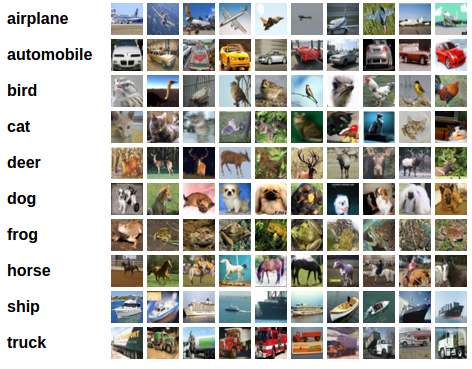

# Plan of actions

In [5]:
"""
Step-by-step procedure:
    [1] Load and normalizing the CIFAR10 training and test datasets using torchvision
    [2] Define a Convolutional Neural Network
    [3] Define a loss function
    [4] Train the network on the training data
    [5] Test the network on the test data
"""

'\nStep-by-step procedure:\n    [1] Load and normalizing the CIFAR10 training and test datasets using torchvision\n    [2] Define a Convolutional Neural Network\n    [3] Define a loss function\n    [4] Train the network on the training data\n    [5] Test the network on the test data\n'

# CPU or GPU

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


# Step #1

In [7]:
"""
The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of 
normalized range [-1, 1].

ISSUE? Loading and converting data into formats that are ready for training can often end up being one of the areas in
data science that sucks up far too much of our time. 
SOLUTION? PyTorch has developed standard conventions of interacting with data that make it fairly consistent to work
with, whether you’re working with images, text, or audio.
IN PRACTICE? The two main conventions of interacting with data are datasets and data loaders. 
    [1] A dataset is a Python class that allows us to get at the data we’re supplying to the neural network. 
    [2] A data loader is what feeds data from the dataset into the network. (This can encompass information such as,
    How many worker processes are feeding data into the network? or How many images are we passing in at once?)
    

WHY DO WE NORMALISE? Normalizing is important because a lot of multiplication will be happening as the input passes 
through the layers of the neural network; keeping the incoming values between 0 and 1 prevents the values from
getting too large during the training phase (known as the exploding gradient problem). 


BATCH_SIZE: We could, in theory, set the batch_size to the number of images in the test and training sets so the
network sees every image before it updates. In practice, we tend not to do this because smaller batches 
(more commonly known as mini-batches in the literature) require less mem‐ ory than having to store all the 
information about every image in the dataset, and the smaller batch size ends up making training faster as 
we’re updating our network much more quickly.
"""

'\nThe output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of \nnormalized range [-1, 1].\n\nISSUE? Loading and converting data into formats that are ready for training can often end up being one of the areas in\ndata science that sucks up far too much of our time. \nSOLUTION? PyTorch has developed standard conventions of interacting with data that make it fairly consistent to work\nwith, whether you’re working with images, text, or audio.\nIN PRACTICE? The two main conventions of interacting with data are datasets and data loaders. \n    [1] A dataset is a Python class that allows us to get at the data we’re supplying to the neural network. \n    [2] A data loader is what feeds data from the dataset into the network. (This can encompass information such as,\n    How many worker processes are feeding data into the network? or How many images are we passing in at once?)\n    \n\nWHY DO WE NORMALISE? Normalizing is important because a lot of m

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


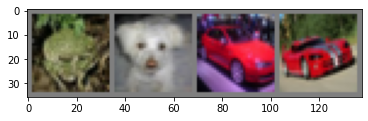

 frog   dog   car   car


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Step #2

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# Instatiate the CNN
net = Net()

# Step #3

In [12]:
"""
Let’s use a Classification Cross-Entropy loss and SGD with momentum.
"""

'\nLet’s use a Classification Cross-Entropy loss and SGD with momentum.\n'

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Step #4

In [14]:
"""
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs
to the network and optimize.
"""

'\nThis is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs\nto the network and optimize.\n'

In [15]:
# Loop over the dataset multiple times
for epoch in range(2):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print every 2000 mini-batches
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0        

print('Finished Training')

[1,  2000] loss: 2.165
[1,  4000] loss: 1.766
[1,  6000] loss: 1.626
[1,  8000] loss: 1.556
[1, 10000] loss: 1.492
[1, 12000] loss: 1.439
[2,  2000] loss: 1.391
[2,  4000] loss: 1.340
[2,  6000] loss: 1.325
[2,  8000] loss: 1.271
[2, 10000] loss: 1.291
[2, 12000] loss: 1.262
Finished Training


In [16]:
workingDirectory = os.getcwd()
PATH = os.path.join(workingDirectory, 'cifar_net.pth')
torch.save(net.state_dict(), PATH)

# Step #5

In [17]:
"""
We have trained the network for 2 passes over the training dataset. But we need to check if the network has 
learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against 
the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.
"""

'\nWe have trained the network for 2 passes over the training dataset. But we need to check if the network has \nlearnt anything at all.\n\nWe will check this by predicting the class label that the neural network outputs, and checking it against \nthe ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.\n\nOkay, first step. Let us display an image from the test set to get familiar.\n'

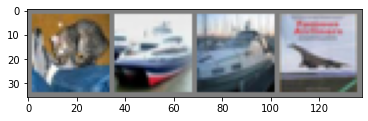

GroundTruth:    cat  ship  ship plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
"""
Let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only
did it to illustrate how to do so):
"""

'\nLet’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only\ndid it to illustrate how to do so):\n'

In [20]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
"""
The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks 
that the image is of the particular class. So, let’s get the index of the highest energy:
"""

'\nThe outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks \nthat the image is of the particular class. So, let’s get the index of the highest energy:\n'

In [22]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [23]:
"""
It is getting 2 out of 4 wrong!
Let us look at how the network performs on the whole dataset.
"""

'\nIt is getting 2 out of 4 wrong!\nLet us look at how the network performs on the whole dataset.\n'

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [25]:
"""
That looks way better than chance, which is 10% accuracy (RANDOMLY PICKING a class out of 10 classes). 
Seems like the network learnt something. Let's now investigate a bit more: what are the classes that 
performed well, and the classes that did not perform well:
"""

"\nThat looks way better than chance, which is 10% accuracy (RANDOMLY PICKING a class out of 10 classes). \nSeems like the network learnt something. Let's now investigate a bit more: what are the classes that \nperformed well, and the classes that did not perform well:\n"

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 64 %
Accuracy of   car : 62 %
Accuracy of  bird : 40 %
Accuracy of   cat : 41 %
Accuracy of  deer : 59 %
Accuracy of   dog : 39 %
Accuracy of  frog : 55 %
Accuracy of horse : 67 %
Accuracy of  ship : 72 %
Accuracy of truck : 60 %


# References


- https: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
- Pointer, Ian. Programming PyTorch for Deep Learning: Creating and Deploying Deep Learning Applications. " O'Reilly Media, Inc.", 2019

